In [1]:
import numpy as np
import matplotlib.pyplot as plt
N = 8
nTherm = 500
lamda = N**2
T = 1
h = 1
J = 1
beta = 1/T

def generate_spin_config(N):
    return 2*np.random.randint(2, size=(N,N))-1

def neighbors(s,x,y):
    left = s[y][x-1]
    right = s[y][(x+1)%N]
    bottom = s[(y+1)%N][x]
    top = s[y-1][x]
    return left, right, bottom, top

def calc_delta_S(s,J,h,x,y,N):
    return 2 * s[y][x]*(J*(np.sum(neighbors(s,x,y))) + h)

def numerical(J, h, N, T):
    spin_conf = generate_spin_config(N)
    plot_x = []
    plot_y = []
    for i in range(nTherm):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        delta_S = calc_delta_S(spin_conf,J,h,x,y,N)
        if np.random.uniform(0,1) <= np.exp(-beta*delta_S): # also accept
            spin_conf[y][x] *= -1
        plot_x.append(i)
        plot_y.append(np.mean(spin_conf))
    plt.plot(plot_x,plot_y)

# Exercise 02 - Simulation of the 2d-Ising-model
The two-dimensional Ising-model is studied via a Markov-Chain-Monte-Carlo-Simulation (MCMC) and the results will be compared to analytically calculated solutions.
## Theory
Similar to the one dimensional case, the hamiltonian for the two-dimensional spin-lattice $\mathbf{s}$ in an external magnetic field $h$ in a heat bath of temperature $T$ and with side lengths $N$ is given by 
$$\mathcal{H}(\mathbf{s})=-J\sum_{\langle x,y\rangle}s_xs_y-h\sum_{x}^Ns_x, $$ where $x$ now numbers the lattice site. $\langle x,y\rangle$ denotes the sum over the nearest neighbors, thus $J$ is the coupling strength between the spins. Periodic boundary conditions are assumed in each direction. The probability of finding a specific spin configuration $\mathbf{s}$ is given by 

$$\mathbf{P}(\mathbf{s})=\exp{\bigg(-\frac{\mathcal{H}(\mathbf{s})}{k_bT}\bigg)}/\sum_{\mathbf{s'}}\exp{\bigg(-\frac{\mathcal{H}(\mathbf{s'})}{k_bT}\bigg)}:=\frac{1}{Z}\exp{\bigg(-\frac{\mathcal{H}(\mathbf{s'})}{k_bT}\bigg)}$$

with the partition function $Z:=\sum_{\mathbf{s'}}\exp{\left(\frac{-\mathcal{H}(\mathbf{s'})}{k_BT}\right)}$. In the thermodynamic limit ($N\to\infty$) solutions for energy per site $\epsilon$ and magnetization per spin $m$ with $h=0$ are known:

$$|m|=\begin{cases}
    \left(1-\frac{1}{\sinh ^{4}(2.7)}\right)^{1 / 8} & \forall J>J_c \\
    0 & \forall J\leq J_c
    \end{cases}
$$
Where $J_c=

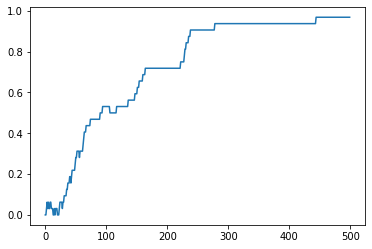

In [2]:
numerical(J, h, N, T)